In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import make_index

import satpy

import pandas as pd
import xarray as xr

import netCDF4

import cartopy.crs as ccrs

from satpy.readers.utils import bbox, get_geostationary_angle_extent

from utils import spherical_angle_add, ABI_BANDS, AHI_BANDS

from pathlib import Path

import warnings

# Develop

In [10]:
f = 'l1b/g16/20200925T1800/01/OR_ABI-L1b-RadF-M6C01_G16_s20202691800201_e20202691809509_c20202691809570.nc'

In [13]:
area = make_index.get_area([f])

No filenames found for reader: scatsat1_l2b
No filenames found for reader: tropomi_l2
No filenames found for reader: nwcsaf-msg2013-hdf5
No filenames found for reader: olci_l2
No filenames found for reader: ahi_hsd
No filenames found for reader: clavrx
No filenames found for reader: cmsaf-claas2_l2_nc
No filenames found for reader: iasi_l2
No filenames found for reader: omps_edr
No filenames found for reader: viirs_compact
No filenames found for reader: nwcsaf-geo
No filenames found for reader: sar-c_safe
No filenames found for reader: mimicTPW2_comp
No filenames found for reader: goes-imager_nc
No filenames found for reader: olci_l1b
No filenames found for reader: agri_l1
No filenames found for reader: modis_l1b
No filenames found for reader: modis_l2
No filenames found for reader: seviri_l1b_native
No filenames found for reader: fci_l2_nc
No filenames found for reader: glm_l2
No filenames found for reader: slstr_l1b
No filenames found for reader: slstr_l2
No filenames found for reade

In [14]:
area.shape

(10848, 10848)

In [1]:
height, width = 100,100

In [23]:
xang, yang = get_geostationary_angle_extent(area)

In [24]:
x,y = np.meshgrid(np.linspace(-xang, xang,width), np.linspace(-yang, yang, height))

In [25]:
proj = area.to_cartopy_crs()

In [26]:
h = proj.proj4_params['h']

In [27]:
lon,lat = ccrs.PlateCarree().transform_points(proj, y*h, x*h).T[:2]

$$ \cos c= \cos a \cos b + \sin a \sin b \cos C $$

![trig](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/Spherical_trigonometry_basic_triangle.svg/400px-Spherical_trigonometry_basic_triangle.svg.png)

In [28]:
# def spherical_angle_add(a, b):
#     C = np.pi/2  # a1 and a2 are orthogonal
#     cosc = np.cos(a)*np.cos(b)+abs(np.sin(a)*np.sin(b))*np.cos(C)
#     c = np.arccos(cosc)
#     return c

In [29]:
a = np.deg2rad(lon - proj.proj4_params['lon_0'])
b = np.deg2rad(lat)
star_zen = np.rad2deg(spherical_angle_add(a, b))

/data/cphillips/isccp-ng/isccp_l1g_prototype/utils.py:31: RuntimeWarning: invalid value encountered in cos
  cosc = np.cos(a)*np.cos(b)+abs(np.sin(a)*np.sin(b))*np.cos(C)
/data/cphillips/isccp-ng/isccp_l1g_prototype/utils.py:31: RuntimeWarning: invalid value encountered in sin
  cosc = np.cos(a)*np.cos(b)+abs(np.sin(a)*np.sin(b))*np.cos(C)


In [30]:
sat_ang = np.rad2deg(spherical_angle_add(x, y))

In [31]:
sat_zen = sat_ang + star_zen

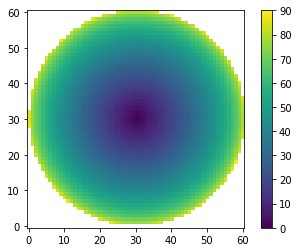

In [19]:
# imshow(sat_zen, origin='lower', vmin=0, vmax=90)
# colorbar();

# Run all

In [10]:
def get_satzen(area):
    height, width = area.shape
    xang, yang = get_geostationary_angle_extent(area)
    x,y = np.meshgrid(np.linspace(-xang, xang,width, dtype=np.float32),
                      np.linspace(-yang, yang, height, dtype=np.float32))
    proj = area.to_cartopy_crs()
    h = proj.proj4_params['h']
    lon,lat = ccrs.PlateCarree().transform_points(proj, y*h, x*h).T[:2]
    a = np.deg2rad(lon - proj.proj4_params['lon_0'])
    b = np.deg2rad(lat)
    star_zen = np.rad2deg(spherical_angle_add(a, b))
    sat_ang = np.rad2deg(spherical_angle_add(x, y))
    sat_zen = sat_ang + star_zen
    return sat_zen.astype(np.float32)

In [11]:
SATZEN_CACHE = Path('satzen_cache')
SATZEN_CACHE.mkdir(exist_ok=True)

In [12]:
L1B = Path('l1b')

In [13]:
encoding = {
    'satzen':{
        'zlib':True,
        'scale_factor':.1,
        'dtype':'i2',
        '_FillValue':netCDF4.default_fillvals['i2']
    }
}

In [14]:
cache = {}
for sat, band_lookup, reader in [('g16', ABI_BANDS, 'abi_l1b'),
            ('g17', ABI_BANDS, 'abi_l1b'),
            ('h8', AHI_BANDS, 'ahi_hsd')]:
    for dt in (L1B / sat).glob('*'):
        band = band_lookup['temp_11_00um']
        files = list((dt / f'{band:02d}').glob('*'))
        area = make_index.get_area(files, reader=reader)
        sat_zen = get_satzen(area)
        
        ds = xr.Dataset()
        ds['satzen'] = ['y','x'], sat_zen
        out = SATZEN_CACHE / f'{sat}_satzen.nc'
        print(out)
        ds.to_netcdf(out, encoding=encoding)
        break

satzen_cache/g16_satzen.nc
satzen_cache/g17_satzen.nc


/data/cphillips/miniconda3/envs/dev/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


satzen_cache/h8_satzen.nc


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import make_geometry

In [4]:
from pathlib import Path

In [7]:
make_geometry.make_geometry(Path('l1b/20200930T0200/'))

 67%|██████▋   | 2/3 [00:37<00:18, 18.71s/it]/data/cphillips/miniconda3/envs/dev/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
100%|██████████| 3/3 [00:57<00:00, 19.30s/it]
